# Python Processing Step for Multilabel FAIMS Data

### Packages

In [1]:
#Load all my packages
import pandas as pd
import numpy as np
import numpy as np
from numpy import array
from numpy import argmax         #finds the index of the maximum value in a vector

import sklearn
import sklearn.ensemble
import skmultilearn
from scipy import sparse
import matplotlib.pyplot as plt
import tensorflow as tf
from skmultilearn.model_selection import  iterative_train_test_split

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# stuff for exploring the classes
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.dataset import load_dataset
from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split, iterative_stratification
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.cluster.igraph import IGraphLabelGraphClusterer
import igraph as ig

### Functions

In [4]:
#Defining the function for adding the pyteomic pieces
from pyteomics import mass
from pyteomics import parser
from pyteomics import electrochem


def addfeatures(featurestable, seqlabel = 'Sequence'):
    Mass = list()
    pI = list()
    Charge = list()
    
    for i in range(0, featurestable.shape[0]):
        ps = parser.parse(featurestable[seqlabel][i], show_unmodified_termini=True)
        
        Mass.append(mass.calculate_mass(parsed_sequence=ps))
        Charge.append(electrochem.charge(ps, 2.5))
        pI.append(electrochem.pI(featurestable[seqlabel][i]))
        
    
    featurestable['pyMass'] = Mass
    featurestable['pI'] = pI
    featurestable['pyCharge'] = Charge
    
    return(featurestable)



#WANT TO TRY ONE-HOT WITH LIST THAT I THEN CONVERT INTO FRAME AFTERWARD
#WOULD ALSO ALLOW FOR THE USE OF THE KARAS PADDING FUNCTION SO THAT I CAN HIT THEM ALL WITH ZEROS AT THE SAME TIME



def simpleOneHot(data_frame, sequenceTag = 'ModSequence', alphabet = 'ACDEFGHIKLMNPQRSTVWY'):
    #Start by finding the max and calculating needed vector length
    VEC_LENGTH = max(data_frame['Length']) * len(alphabet)
    
    #Define what residues are possible
    AMINO_ACIDS = alphabet 
    
    #TURNING CHARACTERS INTO INTEGERS
    # Map character keys to integer values in a dictionary, then map integer keys to character values to revers transform
    char_to_int = dict((c, i) for i, c in enumerate(AMINO_ACIDS))   #character keys to integer values
    int_to_char = dict((i, c) for i, c in enumerate(AMINO_ACIDS))   #integer keys to character values
    
    
    hotlist = list()
    #Build out the rest of the sequences' one-hot arrays
    
    for i in range(0, data_frame.shape[0]):
        
        pep = data_frame[sequenceTag][i]
        #print(pep)
        integer_encode = [char_to_int[char] for char in pep]
        encoded = to_categorical(integer_encode, num_classes=22)
        flatencode = encoded.flatten()
        
        #numzeros = VEC_LENGTH - len(flatencode)
        #flatencode = np.append(flatencode, [[0] * numzeros])
        
        hotlist.append(flatencode)
    
    padded = pad_sequences(hotlist, padding= 'post', maxlen=VEC_LENGTH)
    
    hotarray = np.array(padded)
    
    hotarray.shape
    return(hotarray)

### Processing

In [5]:
#Bringing in the the final labelling scheme data and adding the other features
data_df = pd.read_csv("P:/JGM_FAIMS_CVprediction/JMM_PreProcessed_Data/50percentMaxPlusThreshold.csv", low_memory=False) #read in data generated from R preprocessing
data_df = addfeatures(data_df)
data_hotarray = simpleOneHot(data_frame=data_df, alphabet='ACDEFGHIKLMNPQRSTVWYam')
feature_subset = ['Charge', 'Length', 'pyMass', 'pI']
#Generating X and y, features and labels respectively 
X = np.concatenate((data_df[feature_subset], data_hotarray), axis = 1)
y = data_df.loc[ : ,  'X20':'X95'].values

In [6]:
y.shape

(122847, 16)

In [7]:
X.shape

(122847, 1104)

In [8]:
#Making unique keys for Xs so can be reattached to after iterative train test split
keys = np.transpose(np.array([range(0, data_df.shape[0])]))
X_keys = np.concatenate((keys, X), axis=1)

In [9]:
X_keys[1]

array([ 1.,  2., 14., ...,  0.,  0.,  0.])

In [10]:
#Split the 50%+ threshold data into train and test keeping label distribution proportional
X_train, y_train, X_test, y_test = iterative_train_test_split(X_keys, y, test_size=0.30)
X_train.shape

(85992, 1105)

In [11]:
y_train[1]


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

# Explore the classes

In [12]:
len(y[1])

16

In [13]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y)
print("{} labels, {} edges".format(len(y[1]), len(edge_map)))
print(edge_map)

16 labels, 66 edges
{(6, 7): 16741.0, (6, 8): 5937.0, (7, 8): 14873.0, (3, 4): 12975.0, (7, 9): 4052.0, (8, 9): 9697.0, (7, 10): 1460.0, (8, 10): 5288.0, (9, 10): 8372.0, (1, 2): 3055.0, (10, 11): 7697.0, (2, 3): 7371.0, (10, 12): 3232.0, (11, 12): 5122.0, (4, 5): 17640.0, (4, 6): 4292.0, (5, 6): 17998.0, (3, 5): 1498.0, (11, 13): 2064.0, (12, 13): 2976.0, (11, 14): 649.0, (12, 14): 1190.0, (13, 14): 1618.0, (5, 7): 5137.0, (10, 13): 1010.0, (0, 1): 533.0, (12, 15): 328.0, (13, 15): 573.0, (14, 15): 803.0, (7, 11): 140.0, (8, 11): 1317.0, (9, 11): 2889.0, (5, 8): 536.0, (8, 12): 194.0, (9, 12): 587.0, (9, 13): 81.0, (6, 9): 509.0, (11, 15): 140.0, (3, 6): 60.0, (3, 7): 11.0, (4, 7): 206.0, (6, 10): 110.0, (2, 4): 461.0, (0, 2): 42.0, (0, 3): 1.0, (1, 3): 57.0, (8, 13): 26.0, (3, 8): 1.0, (4, 8): 23.0, (10, 14): 227.0, (10, 15): 37.0, (4, 9): 2.0, (5, 9): 15.0, (4, 10): 1.0, (5, 10): 6.0, (9, 14): 6.0, (2, 5): 24.0, (1, 4): 5.0, (7, 12): 19.0, (5, 11): 2.0, (6, 11): 6.0, (5, 12): 1.0, (

In [14]:
# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [15]:
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_keys, y)
partition

array([list([0, 1, 2, 3, 4, 5, 6]),
       list([7, 8, 9, 10, 11, 12, 13, 14, 15])], dtype=object)

In [36]:
[ x[1:] for x in data_df.loc[ : ,  'X20':'X95'].columns.values]

['20',
 '25',
 '30',
 '35',
 '40',
 '45',
 '50',
 '55',
 '60',
 '65',
 '70',
 '75',
 '80',
 '85',
 '90',
 '95']

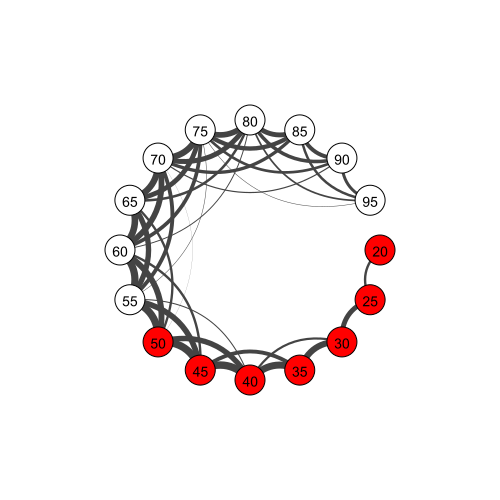

In [38]:

colors = ['red', 'white', 'blue', 'green']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 30,
    "vertex_label": [ x[1:] for x in data_df.loc[ : ,  'X20':'X95'].columns.values],
    "edge_width" : [np.log2(x/100) for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y.shape[1])],
    "bbox": (500,500),
    "margin": 120,
    "layout": clusterer_igraph.graph_.layout_circle(),
    "autocurve":True,
    "edge_curved":0.5
}

def testplot(graph, name):
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(clusterer_igraph.graph_, **visual_style)
    out.save(name + '_all_peptides.png')
    
testplot(clusterer_igraph.graph_, 'test1')
ig.plot(clusterer_igraph.graph_, **visual_style)
#ig.write(clusterer_igraph.graph_, filename="test.svg")

In [39]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(y[1]), len(edge_map)))
print(edge_map)
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_keys, y_train)
partition

16 labels, 64 edges
{(6, 7): 11719.0, (6, 8): 4142.0, (7, 8): 10411.0, (8, 9): 6788.0, (8, 10): 3705.0, (9, 10): 5860.0, (10, 11): 5388.0, (2, 3): 5160.0, (1, 2): 2138.0, (4, 5): 12348.0, (3, 4): 9082.0, (3, 5): 1036.0, (10, 12): 2274.0, (11, 12): 3585.0, (5, 6): 12599.0, (4, 6): 3030.0, (5, 7): 3612.0, (12, 13): 2083.0, (12, 14): 823.0, (13, 14): 1133.0, (7, 9): 2831.0, (7, 10): 1028.0, (9, 11): 2008.0, (5, 8): 376.0, (8, 11): 910.0, (14, 15): 562.0, (11, 13): 1477.0, (11, 14): 459.0, (11, 15): 101.0, (12, 15): 227.0, (13, 15): 406.0, (9, 12): 418.0, (6, 9): 370.0, (6, 10): 86.0, (3, 6): 42.0, (0, 1): 373.0, (10, 13): 738.0, (0, 2): 32.0, (0, 3): 1.0, (1, 3): 38.0, (8, 12): 146.0, (8, 13): 19.0, (9, 13): 62.0, (4, 7): 145.0, (2, 4): 311.0, (4, 8): 16.0, (10, 14): 166.0, (10, 15): 29.0, (7, 11): 97.0, (4, 9): 1.0, (5, 9): 11.0, (4, 10): 1.0, (5, 10): 5.0, (1, 4): 2.0, (2, 5): 19.0, (7, 12): 15.0, (5, 11): 2.0, (6, 11): 5.0, (5, 12): 1.0, (6, 12): 1.0, (3, 7): 8.0, (9, 14): 5.0, (2, 6):

array([list([0, 1, 2, 3, 4, 5, 6]),
       list([7, 8, 9, 10, 11, 12, 13, 14, 15])], dtype=object)

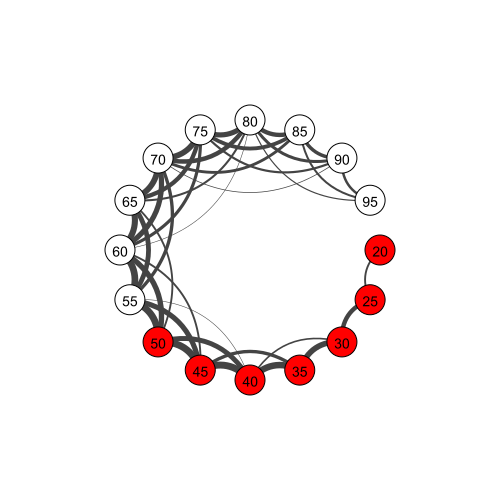

In [40]:
### plottrain set
colors = ['red', 'white', 'blue', 'green']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 30,
    "vertex_label": [ x[1:] for x in data_df.loc[ : ,  'X20':'X95'].columns.values],
    "edge_width" : [np.log2(x/100) for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y.shape[1])],
    "bbox": (500,500),
    "margin": 120,
    "layout": clusterer_igraph.graph_.layout_circle(),
    "autocurve":True,
    "edge_curved":0.5
}

def testplot(graph, name):
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(clusterer_igraph.graph_, **visual_style)
    out.save(name + '_train_peptides.png')
    
testplot(clusterer_igraph.graph_, 'test1')
ig.plot(clusterer_igraph.graph_, **visual_style)
#ig.write(clusterer_igraph.graph_, filename="test.svg")

In [41]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y_test)
print("{} labels, {} edges".format(len(y[1]), len(edge_map)))
print(edge_map)
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_keys, y_test)
partition

16 labels, 60 edges
{(3, 4): 3893.0, (7, 8): 4462.0, (7, 9): 1221.0, (8, 9): 2909.0, (7, 10): 432.0, (8, 10): 1583.0, (9, 10): 2512.0, (1, 2): 917.0, (6, 7): 5022.0, (10, 11): 2309.0, (10, 12): 958.0, (11, 12): 1537.0, (2, 3): 2211.0, (4, 5): 5292.0, (4, 6): 1262.0, (5, 6): 5399.0, (11, 13): 587.0, (12, 13): 893.0, (11, 14): 190.0, (12, 14): 367.0, (13, 14): 485.0, (5, 7): 1525.0, (10, 13): 272.0, (0, 1): 160.0, (12, 15): 101.0, (13, 15): 167.0, (14, 15): 241.0, (7, 11): 43.0, (8, 11): 407.0, (9, 11): 881.0, (6, 8): 1795.0, (5, 8): 160.0, (3, 5): 462.0, (8, 12): 48.0, (9, 12): 169.0, (9, 13): 19.0, (6, 9): 139.0, (3, 6): 18.0, (3, 7): 3.0, (4, 7): 61.0, (6, 10): 24.0, (2, 4): 150.0, (3, 8): 1.0, (4, 8): 7.0, (10, 14): 61.0, (0, 2): 10.0, (8, 13): 7.0, (11, 15): 39.0, (9, 14): 1.0, (2, 5): 5.0, (5, 9): 4.0, (5, 10): 1.0, (1, 3): 19.0, (7, 12): 4.0, (10, 15): 8.0, (1, 4): 3.0, (2, 6): 1.0, (6, 11): 1.0, (4, 9): 1.0, (7, 13): 1.0}


array([list([0, 1, 2, 3, 4, 5, 6]),
       list([7, 8, 9, 10, 11, 12, 13, 14, 15])], dtype=object)

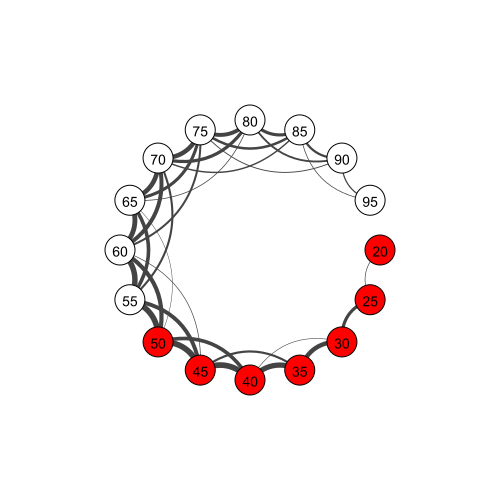

In [42]:
### plottrain set
colors = ['red', 'white', 'blue', 'green']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 30,
    "vertex_label": [ x[1:] for x in data_df.loc[ : ,  'X20':'X95'].columns.values],
    "edge_width" : [np.log2(x/100) for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y.shape[1])],
    "bbox": (500,500),
    "margin": 120,
    "layout": clusterer_igraph.graph_.layout_circle(),
    "autocurve":True,
    "edge_curved":0.5
}

def testplot(graph, name):
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(clusterer_igraph.graph_, **visual_style)
    out.save(name + '_test_peptides.png')
    
testplot(clusterer_igraph.graph_, 'test1')
ig.plot(clusterer_igraph.graph_, **visual_style)
#ig.write(clusterer_igraph.graph_, filename="test.svg")

In [23]:
#Pulling out training data to allow for other thresholds to be applied
fulltraining = pd.concat((pd.DataFrame(y_train), data_df.loc[X_train[:, 0],['Sequence','Charge', 'SeqCharge']].reset_index(drop=True), pd.DataFrame(X_train)), axis=1)
fulltraining.to_csv("50percentplusTraining.csv")

In [24]:
#Pulling out test data to test those other thresholds
fulltesting = pd.concat((pd.DataFrame(y_test), data_df.loc[X_test[:, 0],['Sequence','Charge', 'SeqCharge']].reset_index(drop=True), pd.DataFrame(X_test)), axis=1)
fulltesting.to_csv("50percentplusTesting.csv")

In [25]:
X_train

array([[0.00000e+00, 2.00000e+00, 7.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 2.00000e+00, 1.40000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.00000e+00, 3.00000e+00, 2.40000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.22844e+05, 2.00000e+00, 9.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.22845e+05, 2.00000e+00, 1.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.22846e+05, 2.00000e+00, 1.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])